#### Very preliminary look at multiple scatter nr events in background

- Tianyu Zhu Aug 2017

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d
from scipy.special import erf
from scipy.stats import chi2
from numpy import sqrt, exp, pi

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

# Make multihist even easier to use
from contextlib import contextmanager
@contextmanager
def plotting2d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global mh
    mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'), alpha = 1.0 )

@contextmanager
def plotting1d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global ph
    ph.plot()

In [3]:
import lax; print('Using lax version', lax.__version__)
from lax.lichens import sciencerun0, sciencerun1

def read_data_namelist(sources = ['bg'], run_name = 'SR0'):
    run_names_path = ['/home/zhut/data/SingleScatter/data/run_names_v%s_%s.pkl' % (pax_version,source) for source in sources]
    dsets = pd.concat([pd.read_pickle(path) for path in run_names_path])
    
    your_own_path = ['/scratch/midway2/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine' % (pax_version,source) for source in sources]

    name_list = []
    print ('\nHere we used %s data processed by pax %s' %(run_name, pax_version))
    # Check minitree building survival rate / check souce_type composition
    for path in your_own_path:
        name_list.extend ([f[:11] for f in os.listdir(path) if '.pkl' in f])
    for st in dsets.source__type.unique():
        print ('%s : %d / %d' %(st,
                                len(dsets[(dsets.source__type == st) & (dsets.name.isin(name_list))]),
                                len(dsets[(dsets.source__type == st)])
                               ), end = '  ')
    return dsets

def read_data_real(sources = 'bg', read = True, dsets = None):
    path = '/scratch/midway2/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine' % (pax_version,sources)
    path_bc = '/scratch/midway2/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_elist_all' % (pax_version,sources)
    if read:
        try: 
            df_copy = pd.read_pickle(read)
            print (" (datasets)\nTotol events included : %d" %len(df_copy), end = ' ')
            [print (', pass all cuts: %d' % (len(df_copy[df_copy.source__type == st])), end = ' ') for st in dsets.source__type.unique()]
            return df_copy
        except:
            pass
        # Read from pickled files
        df_copy = []
        drops = ['s1_range_90p_area', 'largest_other_s2', 'lone_hit_center_time', 'cs1',
                 's1_pattern_fit', 's2_range_50p_area', 's1_center_time', 's2_range_90p_area',
                 's1_range_50p_area', 's1_area', 's1_y', 'run_number', 's1_x', 
                 's1_area_fraction_top', 's2', 's1_hit_time_std', 'lone_hit_area', 's2_area',
                 'y', 'lone_hit_range_90p_area', 's2_center_time',
                 'lone_hit_hit_time_std', 's2_rise_time', 'cs2', 's1', 'event_number',
                 's2_pattern_fit', 's2_hit_time_std', 'x', 'drift_time', 's2_x',
                 'z', 's1_rise_time', 'lone_hit_range_50p_area', 's2_area_fraction_top', 's2_y',
                ]
        
        for i, file in enumerate(os.listdir(path)):
            if '.pkl' in file:
                global temp, temp_bc
                temp = pd.read_pickle(os.path.join(path,file))
                temp['source__type'] = 'none'
                try:
                    temp.drop(drops, axis = 1, inplace = True)
                except:
                    continue
                try:
                    temp.drop(['lone_hit_x', 'lone_hit_y'], axis = 1, inplace = True)
                except:
                    pass
                
                temp_bc = pd.read_pickle(os.path.join(path_bc,file))
                temp_bc = temp_bc[(temp_bc.cs1 < 5e2) & (temp_bc.cs2 < 1e4)]
                
                df_copy.append(pd.concat([temp, temp_bc], axis = 1, join = 'outer'))                
                if i > np.inf: # << loop number control
                    break
                    
        df_copy = pd.concat(df_copy)
        print (" (datasets)\nTotol events included : %d" %len(df_copy), end = ' ')
        [print (', pass all cuts: %d' % (len(df_copy[df_copy.source__type == st])), end = ' ') for st in dsets.source__type.unique()]
        
        if pax_version == '6.4.2':
            df_copy = use_lax(sciencerun0, df_copy)
        elif pax_version == '6.6.5':
            df_copy = use_lax(sciencerun1, df_copy)
            
        if '.pkl' in read:
            try:
                df_copy.to_pickle(read)
                print('\nSave to %s' % read)
            except:
                pass
            
        return df_copy
    
def use_lax(sr, df_):
    cut = sr.LowEnergyBackground()
    cut.lichen_list = [
                        sr.FiducialCylinder1T(),
                        sr.InteractionExists(),
                        sr.S2Threshold(),
                        sr.S2AreaFractionTop(),
                        sr.S2SingleScatter(),
                        sr.DAQVeto(),
                        sr.S1SingleScatter(),
                        sr.S1AreaFractionTop(),
                        sr.S2PatternLikelihood(),
                        sr.S1PatternLikelihood(),
                        sr.S2Width(),
                        sr.S1MaxPMT(),
                        sr.PreS2Junk(),
                      ]
    return cut.process(df_)

dsets = []
pax_version = '6.4.2'
dsets.append(read_data_namelist(sources = ['bg'], run_name = 'SR0'))
df_bg0 = read_data_real(sources = 'bg', read = '/home/zhut/data/SingleScatter/data/pickles/sr0_bg_final.pkl', dsets = dsets[-1])

pax_version = '6.6.5'
dsets.append(read_data_namelist(sources = ['bg'], run_name = 'SR1'))
df_bg1 = read_data_real(sources = 'bg', read = '/home/zhut/data/SingleScatter/data/pickles/sr1_bg_final.pkl', dsets = dsets[-1])

dsets = pd.concat(dsets, axis = 0)

Using lax version 1.0.0

Here we used SR0 data processed by pax 6.4.2
none : 633 / 635   (datasets)
Totol events included : 102990 , pass all cuts: 78 
Here we used SR1 data processed by pax 6.6.5
none : 1712 / 1763   (datasets)
Totol events included : 180440 , pass all cuts: 718 

In [4]:
def Print_lax_result_in_Wiki_format():    
    from hax import cuts

    df_0 = df_bg0
    cut_names = [col for col in df_0.columns if ('Cut' in col) 
                 and (col != 'CutS2SingleScatter') 
                 and (col != 'CutLowEnergyBackground')
                 and (col != 'CutPreS2Junk')]
    for cut_name in cut_names:
        df_0 = cuts.selection(df_0, df_0[cut_name], desc = cut_name)

    df_1 = df_bg1
    cut_names = [col for col in df_1.columns if ('Cut' in col) 
                 and (col != 'CutS2SingleScatter') 
                 and (col != 'CutLowEnergyBackground')
                 and (col != 'CutPreS2Junk')]
    for cut_name in cut_names:
        df_1 = cuts.selection(df_1, df_1[cut_name], desc = cut_name)

    x = cuts.history(df_0)
    y = cuts.history(df_1)
    cols  = x.columns
    print (cols)
    for ix, row in x.iterrows():
        print ('| %d |' % ix, end = '')
        for c in cols:
            if isinstance(getattr(row,c), float):
                print ('%.3f' %getattr(row,c),end = ' | ')
            else:
                print (getattr(row,c),end = ' | ')
        try:
            z = y.loc[y.selection_desc == row.selection_desc, :]
            for c in cols:
                if isinstance(getattr(row,c), float):
                    print ('%.3f' %getattr(z,c).values[0],end = ' | ')
                else:
                    print (getattr(z,c).values[0],end = ' | ')
        except:
            print ('|', end = '')
        print()
    
    del df_0, df_1

In [5]:
width = 's2_1_range_50p_area'
area = 's2_1_area'
dt1 = 's2_1_delay_is1'
dt2 = 's2_1_delay_is2'
gof = 's2_1_goodness_of_fit'
aft = 's2_1_area_fraction_top'

def area_difference(time_delay):
    return - 55 + (np.clip(time_delay,-np.inf,0)/2.5e4) ** 2 + (np.clip(time_delay,0,np.inf)/2.5e4) ** 2

sel_se = lambda df: df[(~ (getattr(df, area) > 0)) | (getattr(df, area) < 55)]
sel_notse = lambda df: df[(getattr(df, area) > 55)]

sel_pu = lambda df: df[(getattr(df, area) < 110) & (getattr(df, gof) > 15 * (getattr(df, area) -10) ** 0.45)]
sel_notpu = lambda df: df[(getattr(df, area) > 110) | (getattr(df, gof) < 15 * (getattr(df, area) -10) ** 0.45)]

sel_small = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 < area_difference(getattr(df, dt2))]
sel_notsmall = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 > area_difference(getattr(df, dt2))]

# Real definition of the cut
sel_ss = lambda df: df[(~ (getattr(df, area) > 0)) 
                       | (getattr(df, area) < 55) 
                       | ((getattr(df, area) < 110) & (getattr(df, gof) > 15 * (getattr(df, area) -10) ** 0.45)) 
                       | (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 < (getattr(df, dt2) / 2.5e4) ** 2)
                       | ((getattr(df, dt1) > 750e3) & (getattr(df, 'run_number') > 6500))
                       | ((getattr(df, dt1) > 680e3) & (getattr(df, 'run_number') < 6500))
                      ]
sel_ms = lambda df: df[(getattr(df, area) > 55) 
                       & ((getattr(df, area) > 110) | (getattr(df, gof) < 15 * (getattr(df, area) -10) ** 0.45)) 
                       & (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 > (getattr(df, dt2) / 2.5e4) ** 2)
                       & ~((getattr(df, dt1) > 750e3) & (getattr(df, 'run_number') > 6500))
                       & ~((getattr(df, dt1) > 680e3) & (getattr(df, 'run_number') < 6500))
                      ]
                
def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

# Remove some unusually dataset (Labeled as hot spot in run database)
sel_set = lambda df: df[~ df.run_number.isin([10078, 10079, 9226])]
sel_lax_all = lambda df: df[df.source__type == 'none']

cuts_copy = [col for col in df_bg1.columns if ('Cut' in col) 
            and (col != 'CutS2SingleScatter') 
            and (col != 'CutLowEnergyBackground')
            and (col != 'CutPreS2Junk')
           ]

cuts = [col for col in cuts_copy if col != 'CutS1SingleScatter']
scuts_no_s1_ss = '&'.join(cuts)
sel_lax_no_s1_ss = lambda df: df[df.eval(scuts_no_s1_ss) & ~ (df.source__type == 'none')]

cuts = [col for col in cuts_copy if col != 'CutS2AreaFractionTop']
scuts_no_s2_aft = '&'.join(cuts)
sel_lax_no_s2_aft = lambda df: df[df.eval(scuts_no_s2_aft) & ~ (df.source__type == 'none')]

cuts = [col for col in cuts_copy if col != 'CutS1AreaFractionTop']
scuts_no_s1_aft = '&'.join(cuts)
sel_lax_no_s1_aft = lambda df: df[df.eval(scuts_no_s1_aft) & ~ (df.source__type == 'none')]

cuts = [col for col in cuts_copy if col != 'CutS1PatternLikelihood']
scuts_no_s1_pll = '&'.join(cuts)
sel_lax_no_s1_pll = lambda df: df[df.eval(scuts_no_s1_pll) & ~ (df.source__type == 'none')]

cuts = [col for col in cuts_copy if col != 'CutS2PatternLikelihood']
scuts_no_s2_pll = '&'.join(cuts)
sel_lax_no_s2_pll = lambda df: df[df.eval(scuts_no_s2_pll) & ~ (df.source__type == 'none')]

The cut we use to identify multiple scatters looks like this:

New parameters put into the extended minitree are

'other_s2_area', 'other_s2_pattern_fit', 'other_s2_delay_main_s2' and 'other_s2_delay_main_s1'

```python
cut = ~ (df['other_s2_area'] > 0)  # Keep those with none existing largest other s2
cut |= (df['other_s2_area'] < 55)  # Keep those with single electron size largest other s2
cut |= (df['other_s2_area'] - 5 - df['s2'] * 0.025 < (df['other_s2_delay_main_s2'] / 2.5e4) ** 2)
# Keep small ones according to main s2 size and time delay from main s2
cut |= ((df['other_s2_area'] < 110) & (df['other_s2_pattern_fit'] > 15 * (df['other_s2_area'] - 10) ** 0.45)) 
# Keep those with bad hit pattern
cut |= ((df['other_s2_delay_main_s1'] > 750e3) & (df['run_number'] > 6500)) 
cut |= ((df['other_s2_delay_main_s1'] < 680e3) & (df['run_number'] < 6500))
# Keep those after maximum drift time
```

In [6]:
df_ = sel_lax_all(df_bg0)
print ('%d ms out of total %d events in SR0 background as %.4f %%' %(len(sel_ms(df_)),len(df_),100 *len(sel_ms(df_))/len(df_)))
df_ = sel_lax_all(sel_set(df_bg1))
print ('%d ms out of total %d events in SR1 background as %.4f %%' %(len(sel_ms(df_)),len(df_),100 *len(sel_ms(df_))/len(df_)))

3 ms out of total 78 events in SR0 background as 3.8462 %
6 ms out of total 239 events in SR1 background as 2.5105 %


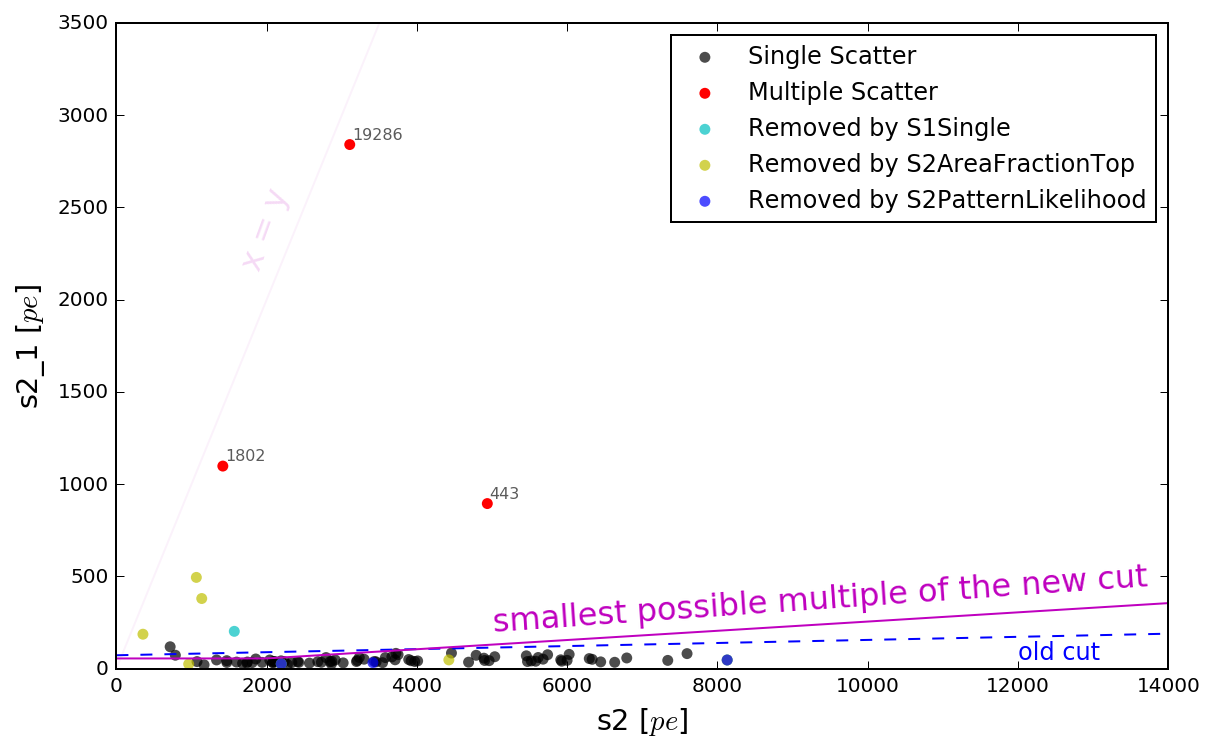

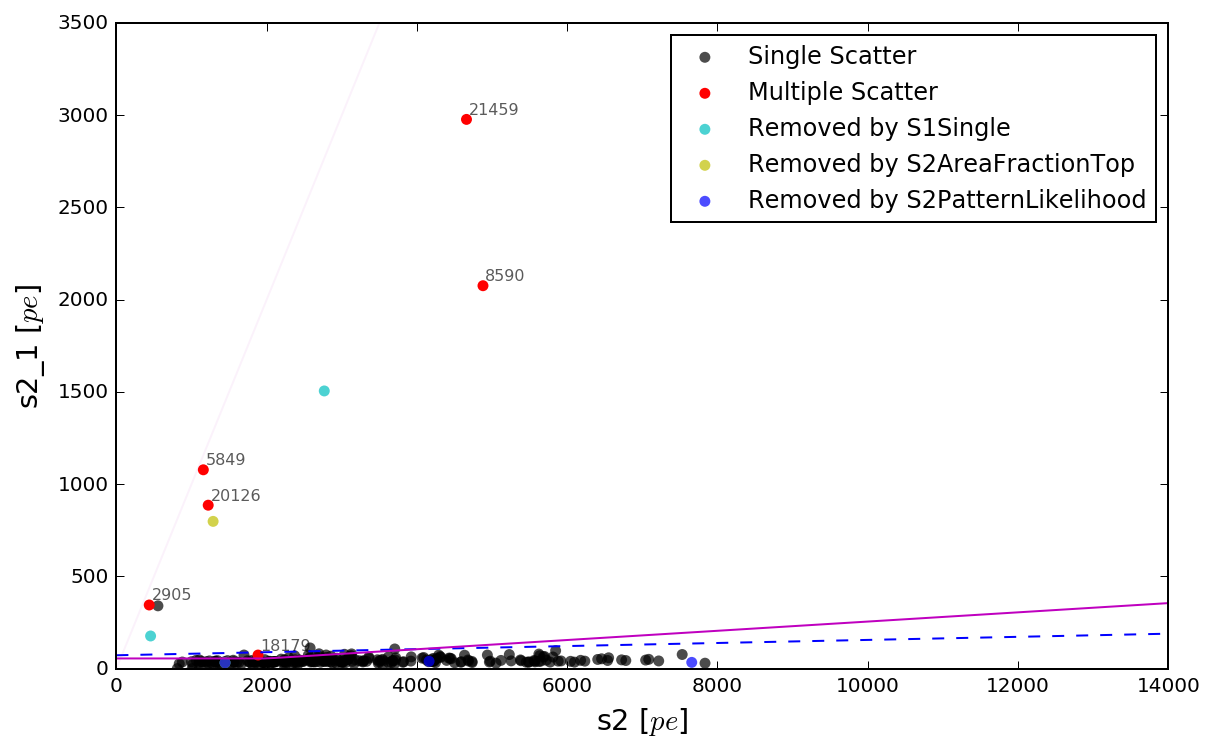

In [7]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
sel_ls1 = lambda df:df[df.s1<100]

def plotsups(text = False):
    x = np.linspace(0,14e3,101)
    plt.plot(x, ses2_size_cut_ori(x), 'b--')
    plt.plot(x, np.clip(5 + x * 0.025, 55, 1e5), 'm-')
    plt.plot(x, x, 'm-', alpha = 0.05)
    if text:
        plt.text(12000, 50, 'old cut', color = 'b', size = 12.0, rotation=0)
        plt.text(1600, 2500, 'x = y', color = 'm', size = 16.0, rotation=70, alpha = 0.15)
        plt.text(5000, 450, 'smallest possible multiple of the new cut', color = 'm', size = 16.0, rotation=4.0)

def add_ids():
    for ix, row in df_.iterrows():
        x = getattr(row, 's2') + 30
        y = getattr(row, area) + 30
        plt.text(x, y, '%d' % getattr(row, 'event_number'),
                 color = 'k', size = 8.0, alpha = 0.65)
        if ix == 1:
            plt.text(x, y-20, '(event number)',
                 color = 'k', size = 8.0, alpha = 0.65)


ops = dict(s=30, edgecolor='none', cmap=plt.get_cmap('viridis'))  #getattr(df_, dt2) / 1000, vmin = -200, vmax = 200, 
ops_2 = dict(xlabel = 's2 [$pe$]', ylabel = 's2_1 [$pe$]', xbounds = [0,14e3], ybounds = [0,3500], sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_ss(sel_lax_all(df_bg0))
ls = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'k', alpha = 0.7, **ops)

df_ = sel_ms(sel_lax_all(df_bg0))
lm = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'r', **ops)
add_ids()

df_ = sel_lax_no_s1_ss(df_bg0)
ls1 = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'c', alpha = 0.7, **ops)

df_ = sel_lax_no_s2_aft(df_bg0)
lft = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'y', alpha = 0.7, **ops)

df_ = sel_lax_no_s2_pll(df_bg0)
lll = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'b', alpha = 0.7, **ops)

plt.legend([ls, lm, ls1, lft, lll],
           ['Single Scatter', 'Multiple Scatter','Removed by S1Single', 'Removed by S2AreaFractionTop', 'Removed by S2PatternLikelihood'],
           loc = 'higher right', scatterpoints=1,)
plt_config(title = '', **ops_2)
plotsups(text = True)

plt.tight_layout()
plt.show()
#####################################################################
# Reinitialize figure in order to save the plots individually
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
#####################################################################
ax = fig.add_subplot(223)
df_ = sel_set(sel_lax_all(sel_ss(df_bg1)))
ls = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'k', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_all(sel_ms(df_bg1)))
lm = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'r', **ops)
add_ids()

df_ = sel_set(sel_lax_no_s1_ss(df_bg1))
ls1 = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'c', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_aft(df_bg1))
lft = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'y', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_pll(df_bg1))
lll = plt.scatter(getattr(df_, 's2'), getattr(df_, 'largest_other_s2'), color = 'b', alpha = 0.7, **ops)

plt.legend([ls, lm, ls1, lft, lll],
           ['Single Scatter', 'Multiple Scatter','Removed by S1Single', 'Removed by S2AreaFractionTop', 'Removed by S2PatternLikelihood'],
           loc = 'higher right', scatterpoints=1,)
plt_config(title = '', **ops_2)
plotsups()

plt.tight_layout()
plt.show()

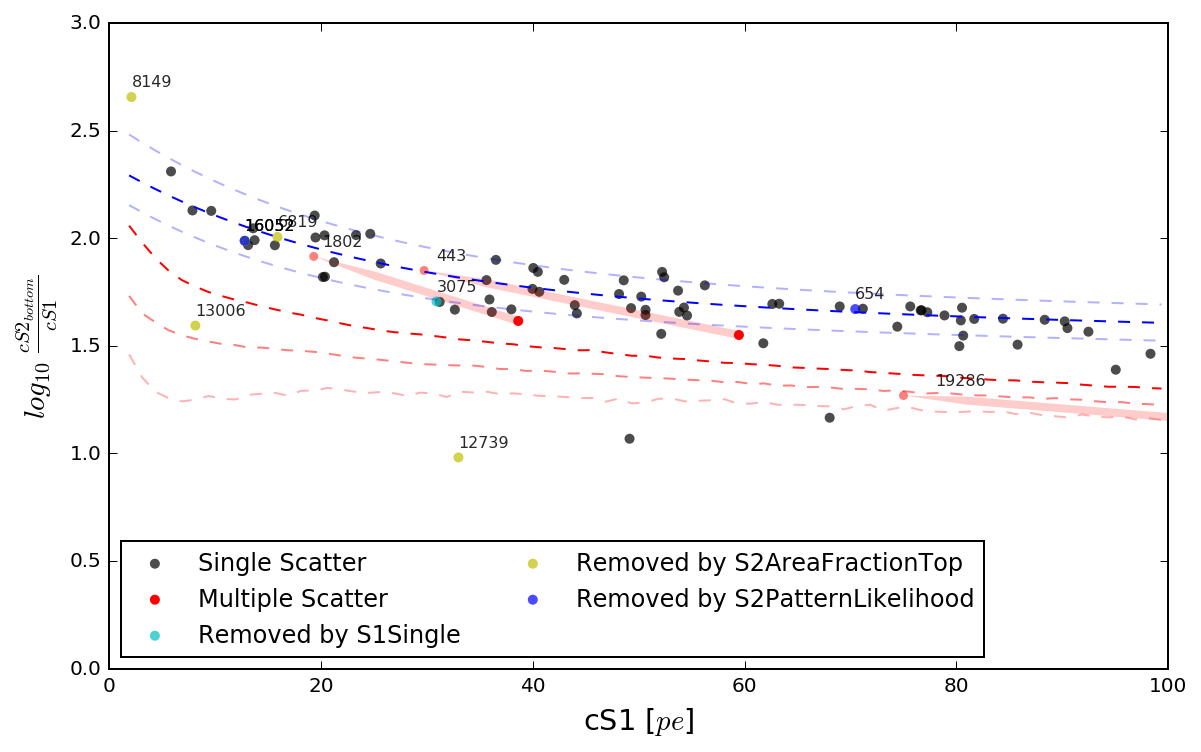

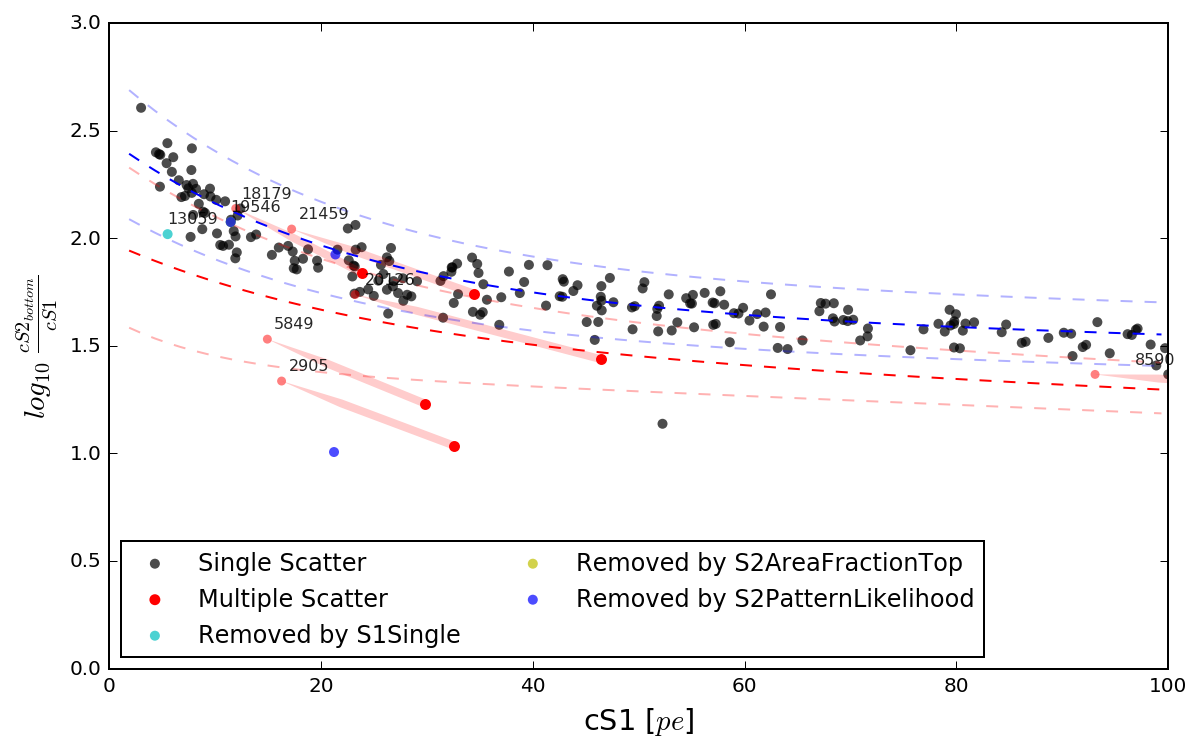

In [8]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
sel_ls1 = lambda df:df[df.s1<100]

import _pickle as pickle    
nb_0 = pickle.load(open('/home/zhut/data/SingleScatter/nr_band_lines_sr0.p','rb'))

def plotsups(text = False):   
    global nr, er
    nr = plt.plot(nb_0['s1'], nb_0['mc_lines'][50], 'r--', alpha = 1)
    plt.plot(nb_0['s1'], nb_0['mc_lines'][10], 'r--', alpha = 0.5)
    plt.plot(nb_0['s1'], nb_0['mc_lines'][1], 'r--', alpha = 0.3)
    
    cs1 = np.linspace(1.875, 99.375, 81)
    mean = exp(-0.428416+(-0.043311)*cs1) + 1.692815 + (-9.554123e-04)*cs1
    sig_low = exp(-0.533424+(-0.0504029)*cs1) + 1.62189 + (-0.00102531)*cs1
    sig_high = exp(-0.269487+(-0.0434837)*cs1) + 1.77962 + (-0.000981318)*cs1
    
    plt.plot(cs1, sig_high, 'b--', alpha = 0.3)
    er = plt.plot(cs1, mean, 'b--', alpha = 1.0)
    plt.plot(cs1, sig_low, 'b--', alpha = 0.3)
    
def plotsups_1(text = False):
    global nr, er
    cs1 = np.linspace(1.875, 99.375, 81)
    sig_high = 0.752646*exp(-cs1/22.6118) + 1.63948 -0.00228754*cs1
    mean = 0.498427*exp(-cs1/24.921) + 1.48388 -0.00197693*cs1
    sig_low = 0.242103*exp(-cs1/9.44781) + 1.38949 -0.00204787*cs1
     
    plt.plot(cs1, sig_high, 'r--', alpha = 0.3)
    nr = plt.plot(cs1, mean, 'r--', alpha = 1.0)
    plt.plot(cs1, sig_low, 'r--', alpha = 0.3)
    
    mean = 0.808636*exp(-cs1/23.0261) + 1.64898 -0.00107802*cs1  
    sig_high = 0.963811*exp(-cs1/21.8973) + 1.80553 -0.00114669*cs1 
    sig_low = 0.630351*exp(-cs1/22.234) + 1.51115 -0.00112959*cs1
    
    plt.plot(cs1, sig_high, 'b--', alpha = 0.3)
    er = plt.plot(cs1, mean, 'b--', alpha = 1.0)
    plt.plot(cs1, sig_low, 'b--', alpha = 0.3)
    
def add_ids(no_shift = False):
    for ix, row in df_.iterrows():
        if no_shift and row.cs1 < 100:
            x = row.cs1
            y = np.log10(row.cs2*(1-row.s2_area_fraction_top)/row.cs1) + 0.05
            plt.text(x, y, '%d' % getattr(row, 'event_number'), color = 'k', size = 8.0, alpha = 0.85)
        elif (not no_shift):
            x = row.cs1 * 0.52
            y = np.log10(row.cs2*(1-row.s2_area_fraction_top)/row.cs1) + 0.35
            plt.text(x, y, '%d' % getattr(row, 'event_number'), color = 'k', size = 8.0, alpha = 0.85)


ops = dict(s=25, edgecolor='none', cmap=plt.get_cmap('viridis'))  #getattr(df_, dt2) / 1000, vmin = -200, vmax = 200, 
ops_2 = dict(xlabel = 'cS1 [$pe$]', ylabel = r'$log_{10}\ \frac{cS2_{bottom}}{cS1}$', xbounds = [0,100], ybounds = [0,3], sci = False)
ops_3 = dict(angles='xy', scale_units='xy', scale=1., color = 'r', alpha = 0.2, edgecolor = 'none', headwidth = 1, headlength = 8)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_lax_all(sel_ss(df_bg0))
ls = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'k', alpha = 0.7, **ops)

df_ = sel_set(sel_ms(df_bg0))
lm = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'r', alpha = 1.0, **ops)
plt.scatter(df_.cs1/2,np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1)+0.3, color = 'r', alpha = 0.5, s=20, edgecolor='none')
plt.quiver(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), - df_.cs1/2, 0.3 * df_.cs1/df_.cs1, **ops_3)
add_ids()

df_ = sel_lax_no_s1_ss(df_bg0)
ls1 = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'c', alpha = 0.7, **ops)
add_ids(no_shift = True)

df_ = sel_lax_no_s2_aft(df_bg0)
lft = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'y', alpha = 0.7, **ops)
add_ids(no_shift = True)

df_ = sel_lax_no_s2_pll(df_bg0)
lll = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'b', alpha = 0.7, **ops)
add_ids(no_shift = True)

plotsups(text = False) 

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by S1Single', 'Removed by S2AreaFractionTop', 'Removed by S2PatternLikelihood',
            'nr median', 'er median'], loc = 'lower left', ncol=2, scatterpoints=1)
plt_config(title = '', **ops_2)


plt.tight_layout()
plt.show()
#####################################################################
# Reinitialize figure in order to save the plots individually
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
#####################################################################
ax = fig.add_subplot(223)
df_ = sel_lax_all(sel_set(sel_ss(df_bg1)))
ls = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'k', alpha = 0.7, **ops)

df_ = sel_lax_all(sel_set(sel_ms(df_bg1)))
lm = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'r')
plt.scatter(df_.cs1/2,np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1)+0.3, color = 'r', alpha = 0.5, s=20, edgecolor='none')
plt.quiver(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), - df_.cs1/2, 0.3 * df_.cs1/df_.cs1, **ops_3)
add_ids()

df_ = sel_set(sel_lax_no_s1_ss(df_bg1))
ls1 = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'c', alpha = 0.7, **ops)
add_ids(no_shift = True)

df_ = sel_set(sel_lax_no_s2_aft(df_bg1))
lft = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'y', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_pll(df_bg1))
lll = plt.scatter(df_.cs1, np.log10(df_.cs2*(1-df_.s2_area_fraction_top)/df_.cs1), color = 'b', alpha = 0.7, **ops)

plotsups_1()

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by S1Single', 'Removed by S2AreaFractionTop', 'Removed by S2PatternLikelihood',
            'nr median', 'er median'], loc = 'lower left', ncol=2, scatterpoints=1)
plt_config(title = '', **ops_2)

plt.tight_layout()
plt.show()

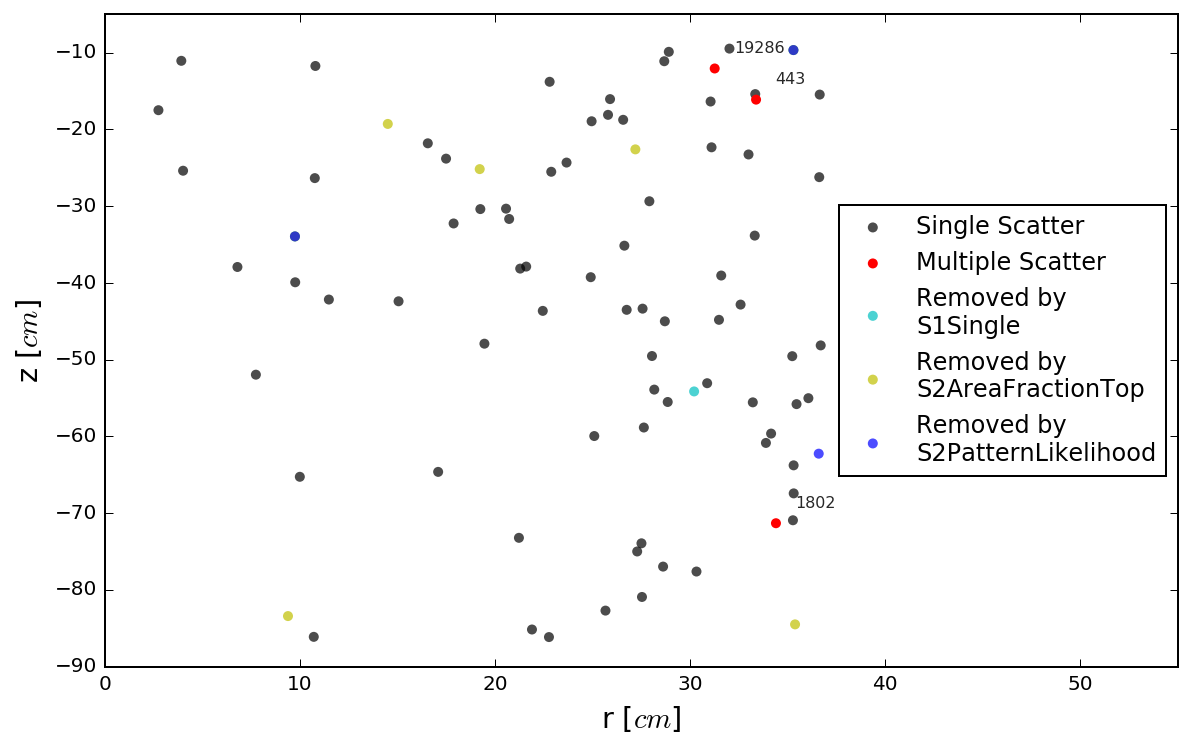

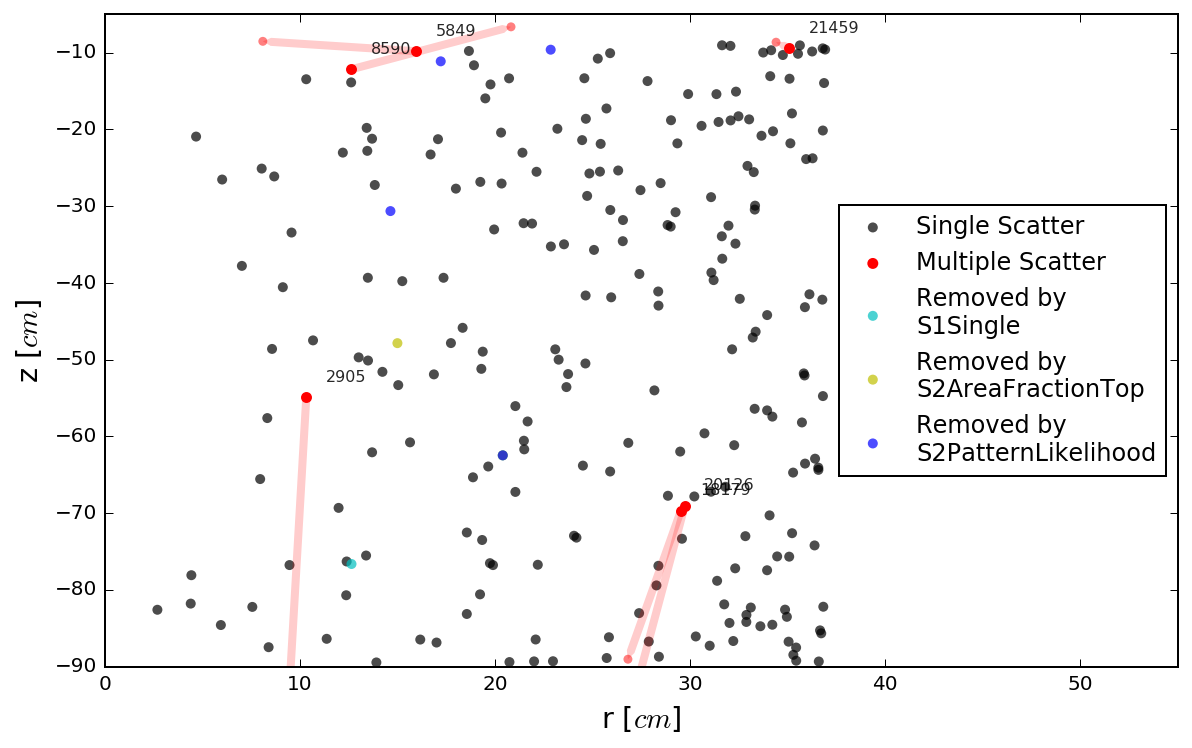

In [12]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
sel_ls1 = lambda df:df[df.s1<100]

import _pickle as pickle    
nb_0 = pickle.load(open('/home/zhut/data/SingleScatter/nr_band_lines_sr0.p','rb'))

def plotsups(text = False):   
    pass
    
    
def plotsups_1(text = False):
    pass
    
def add_ids():
    for ix, row in df_.iterrows():
        x = row.r + 1
        y = row.z + 2
        plt.text(x, y, '%d' % getattr(row, 'event_number'),
                 color = 'k', size = 8.0, alpha = 0.85)


ops = dict(s=25, edgecolor='none', cmap=plt.get_cmap('viridis')) 
ops_2 = dict(xlabel = 'r [$cm$]', ylabel = 'z [$cm$]', xbounds = [0,55], ybounds = [-90,-5], sci = False)
ops_3 = dict(angles='xy', scale_units='xy', scale=1., color = 'r', alpha = 0.2, edgecolor = 'none', headwidth = 1, headlength = 1)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_lax_all(sel_ss(df_bg0))
ls = plt.scatter(df_.r, df_.z, color = 'k', alpha = 0.7, **ops)

df_ = sel_lax_all(sel_ms(df_bg0))
lm = plt.scatter(df_.r, df_.z, color = 'r', alpha = 1.0, **ops)
add_ids()

df_ = sel_lax_no_s1_ss(df_bg0)
ls1 = plt.scatter(df_.r, df_.z, color = 'c', alpha = 0.7, **ops)

df_ = sel_lax_no_s2_aft(df_bg0)
lft = plt.scatter(df_.r, df_.z, color = 'y', alpha = 0.7, **ops)

df_ = sel_lax_no_s2_pll(df_bg0)
lll = plt.scatter(df_.r, df_.z, color = 'b', alpha = 0.7, **ops)

plotsups(text = False) 

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by \nS1Single', 'Removed by \nS2AreaFractionTop', 'Removed by \nS2PatternLikelihood',
            'nr median', 'er median'], loc = 'right', ncol=1, scatterpoints=1)
plt_config(title = '', **ops_2)

plt.tight_layout()
plt.show()
#####################################################################
# Reinitialize figure in order to save the plots individually
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
#####################################################################
ax = fig.add_subplot(223)
df_ = sel_set(sel_lax_all(sel_ss(df_bg1)))
ls = plt.scatter(df_.r, df_.z, color = 'k', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_all(sel_ms(df_bg1)))
lm = plt.scatter(df_.r, df_.z, color = 'r')
plt.scatter(np.sqrt(np.square(df_.s2_1_x) + np.square(df_.s2_1_y)),df_.s2_1_z, color = 'r', alpha = 0.5, s=20, edgecolor='none')
plt.quiver(df_.r, df_.z, np.sqrt(np.square(df_.s2_1_x) + np.square(df_.s2_1_y))-df_.r, df_.s2_1_z-df_.z, **ops_3)
add_ids()

df_ = sel_set(sel_lax_no_s1_ss(df_bg1))
ls1 = plt.scatter(df_.r, df_.z, color = 'c', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_aft(df_bg1))
lft = plt.scatter(df_.r, df_.z, color = 'y', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_pll(df_bg1))
lll = plt.scatter(df_.r, df_.z, color = 'b', alpha = 0.7, **ops)

plotsups_1()

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by \nS1Single', 'Removed by \nS2AreaFractionTop', 'Removed by \nS2PatternLikelihood',
            'nr median', 'er median'], loc = 'right', ncol=1, scatterpoints=1)
plt_config(title = '', **ops_2)

plt.tight_layout()
plt.show()

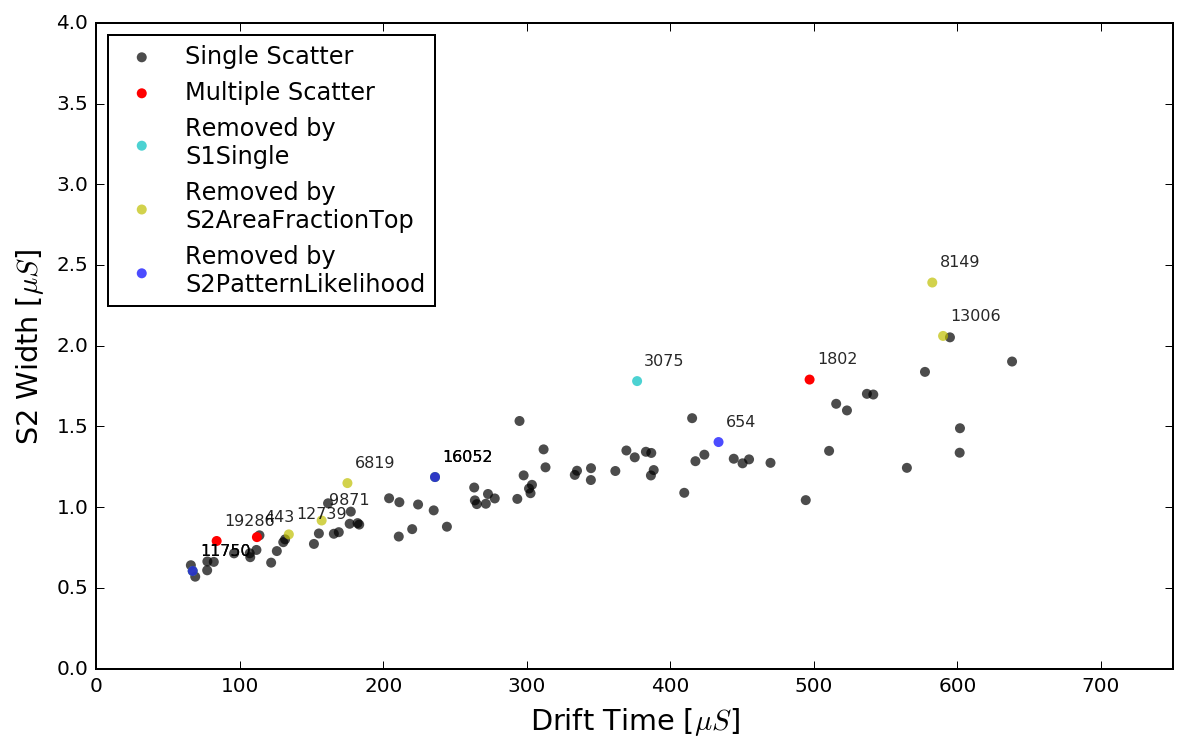

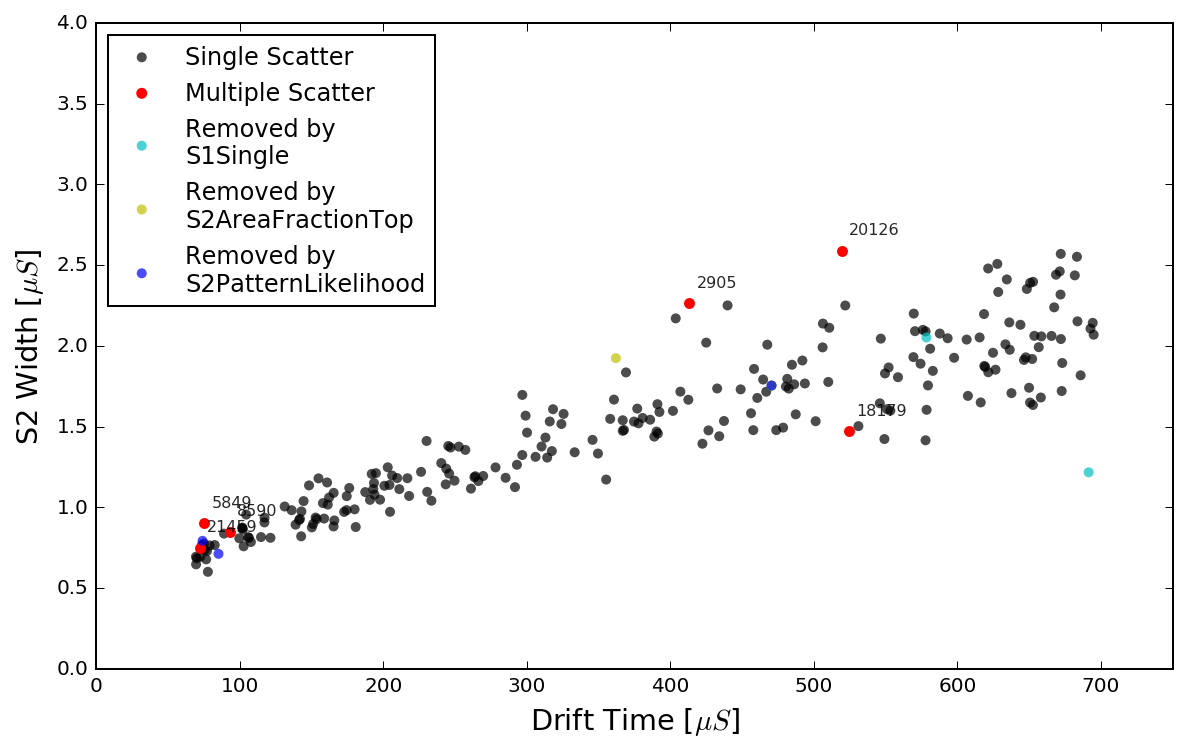

In [117]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
sel_ls1 = lambda df:df[df.s1<100]

import _pickle as pickle    
nb_0 = pickle.load(open('/home/zhut/data/SingleScatter/nr_band_lines_sr0.p','rb'))

def plotsups(text = False):   
    pass
    
    
def plotsups_1(text = False):
    pass
    
def add_ids():
    for ix, row in df_.iterrows():
        x = row.drift_time/1e3 + 5
        y = row.s2_range_50p_area/1e3 + 0.1
        plt.text(x, y, '%d' % getattr(row, 'event_number'),
                 color = 'k', size = 8.0, alpha = 0.85)


ops = dict(s=25, edgecolor='none', cmap=plt.get_cmap('viridis'))  #getattr(df_, dt2) / 1000, vmin = -200, vmax = 200, 
ops_2 = dict(xlabel = 'Drift Time [$\mu S$]', ylabel = 'S2 Width [$\mu S$]', xbounds = [0,750], ybounds = [0,4], sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_lax_all(sel_ss(df_bg0))
ls = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'k', alpha = 0.7, **ops)

df_ = sel_lax_all(sel_ms(df_bg0))
lm = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'r', alpha = 1.0, **ops)
add_ids()

df_ = sel_lax_no_s1_ss(df_bg0)
ls1 = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'c', alpha = 0.7, **ops)
add_ids()

df_ = sel_lax_no_s2_aft(df_bg0)
lft = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'y', alpha = 0.7, **ops)
add_ids()

df_ = sel_lax_no_s2_pll(df_bg0)
lll = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'b', alpha = 0.7, **ops)
add_ids()

plotsups(text = False) 

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by \nS1Single', 'Removed by \nS2AreaFractionTop', 'Removed by \nS2PatternLikelihood',
            'nr median', 'er median'], loc = 'upper left', ncol=1, scatterpoints=1)
plt_config(title = '', **ops_2)
plt.tight_layout()
plt.show()

plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
#####################################################################
ax = fig.add_subplot(223)
df_ = sel_set(sel_lax_all(sel_ss(df_bg1)))
ls = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'k', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_all(sel_ms(df_bg1)))
lm = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'r')
add_ids()

df_ = sel_set(sel_lax_no_s1_ss(df_bg1))
ls1 = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'c', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_aft(df_bg1))
lft = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'y', alpha = 0.7, **ops)

df_ = sel_set(sel_lax_no_s2_pll(df_bg1))
lll = plt.scatter(df_.drift_time/1e3, df_.s2_range_50p_area/1e3, color = 'b', alpha = 0.7, **ops)

plotsups_1()

plt.legend([ls, lm, ls1, lft, lll, nr, er],
           ['Single Scatter', 'Multiple Scatter','Removed by \nS1Single', 'Removed by \nS2AreaFractionTop', 'Removed by \nS2PatternLikelihood',
            'nr median', 'er median'], loc = 'upper left', ncol=1, scatterpoints=1)
plt_config(title = '', **ops_2)

plt.tight_layout()
plt.show()

In [15]:
# IO of neutron candidates
import csv
from IPython.display import Image, display


folders = ['/project/lgrandi/xenon1t/raw',
           '/project2/lgrandi/xenon1t/raw',
           '/project/lgrandi/xenon1t/raw_for_waveforms']

namelist = []
for fo in folders:
    if 'waveforms' in fo:
        namelist.append([fi[:11] for fi in os.listdir(fo) if (not 'tpc' in fi)]
                        + [fi[10:21] for fi in os.listdir(fo) if ('tpc' in fi)]
                       )
    else:
        namelist.append([fi[:11] for fi in os.listdir(fo) if (not 'MV' in fi and not 'lst' in fi)])
    
    
for srun in ['0', '1']:

    if srun == '0':
        df_ = sel_set(sel_ms(df_bg0))
        file_name = 'sr0_bg_ms'
    elif srun == '1':
        df_ = sel_set(sel_ms(df_bg1))
        file_name = 'sr1_bg_ms'

    path2wfinspector = '/home/zhut/data/waveforminspectors/batch_production/example_lists/%s' % file_name
    if not os.path.exists(path2wfinspector):
        os.makedirs(path2wfinspector)

    for index, rn in enumerate(df_.run_number.unique()):

        if False:
            # Write to text file
            text_file = open(os.path.join(path2wfinspector,'%d.txt' % rn), "w")
            for ix, en in enumerate(df_[df_.run_number == rn].event_number):
                if ix != 0: text_file.write('\n')
                text_file.write('%d' % en)

            text_file.close()

        if False:
            # Write to csv file
            csv_file = open(os.path.join(path2wfinspector,'%s.csv' % file_name), "a")
            writer = csv.writer(csv_file, delimiter=',',quoting=csv.QUOTE_MINIMAL)
            for ix, en in enumerate(df_[df_.run_number == rn].event_number):
                writer.writerow([rn, en])

            csv_file.close()

        if False:
            # Print the information here
            if index == 0:
                print ('Indentified as multiple scatter in sr %s' % srun)
                print ('{:2} {:^13} {:^13} {:^13}'.format('','run_number','event_number','run_name'))
            run_name = dsets.loc[dsets.number == rn, 'name'].values[0]
            for i in range(len(df_[df_.run_number == rn])):
                run_number = df_.loc[df_.run_number == rn, 'run_number'].values[i]
                event_number = df_.loc[df_.run_number == rn, 'event_number'].values[i]
                print ('{:2} {:^13} {:^13} {:^13}'.format('', run_number, event_number, run_name))
                run_name = '-'*11
        
        if False:
            # Show made wf png's here
            for i in range(len(df_[df_.run_number == rn])):
                event_number = df_.loc[df_.run_number == rn, 'event_number'].values[i]
                path = '/project/lgrandi/zhut/data/SingleScatter/waveforminspector/sr%s/' % srun
                file = '{:06}_{:06}.png'.format(0, event_number)
                try:
                    display(Image(os.path.join(path, file), width=700, height=400))
                except:
                    pass
        
        if False:
            # Print where the raw data area stored
            # Still not working
            for ix, nl in enumerate(namelist):
                if run_name in nl:
                    print (folders[ix])


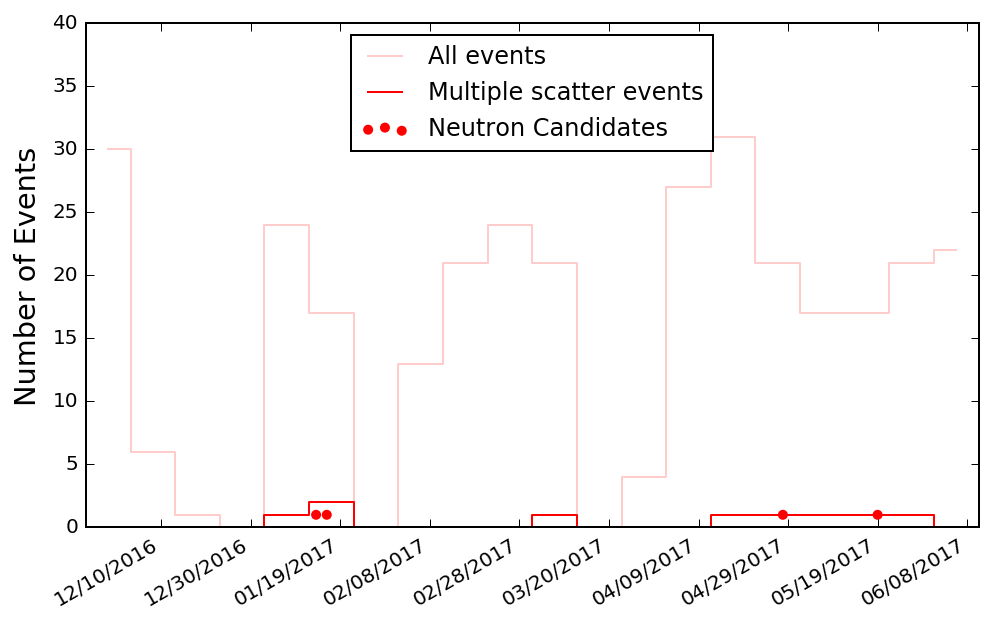

In [17]:
# Time evolution (Take some time to init hax)

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import hax
hax.init(experiment='XENON1T')
datasets = hax.runs.datasets

plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

df_ = sel_lax_all(sel_set(pd.concat([df_bg0, df_bg1])))
df_ = df_[(df_.cs1<200) & (df_.source__type == 'none')]
df_['datetime'] = 0
for ix, run_number in enumerate(df_.run_number.unique()):  
    run_name = datasets.loc[datasets.number == run_number, 'name'].values[0]
    date = datetime(year = 2000 + int(run_name[0:2]), 
                    month = int(run_name[2:4]), 
                    day = int(run_name[4:6]),
                    hour = int(run_name[7:9]),
                    minute = int(run_name[9:11])
                   )
    
    df_.loc[df_.run_number == run_number, 'run_name'] = run_name
    df_.loc[df_.run_number == run_number, 'datetime'] = matplotlib.dates.date2num(date)

r = [min(df_.datetime), max(df_.datetime)]
dr = max(df_.datetime) - min(df_.datetime)

ph = Hist1d(df_.datetime, range = r, bins = 20)
ph.plot(alpha = 0.2, color = 'r')

df_ = sel_ms(df_)
ph = Hist1d(df_.datetime, range = r, bins = 20)
ph.plot(alpha = 1.0, color = 'r')

df_ = df_[df_.event_number.isin ([19286, 443, 21459, 5849])]
plt.scatter(df_.datetime, np.ones(4), s=25, edgecolor='none', color = 'r')

plt.legend(['All events', 'Multiple scatter events', 'Neutron Candidates'], loc = 'upper center')
    
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 20))
plt.gcf().autofmt_xdate()
plt_config(title = '', xbounds = r, ybounds = [0, 40], 
           ylabel = 'Number of Events')

plt.show()